In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from pprint import pp

In [2]:
files = os.listdir("logs")
settings = {}

for fname in files:
    with open(f"logs/{fname}", "r", encoding="utf-8") as fin:
        lines = list(fin)
        d = json.loads(lines[0])
        d.pop("datasets")

        epochs, loss, recall, precision, ndcg = lines[-1].strip().split("\t")

        d["epochs"] = int(epochs)
        d["loss"] = float(loss)
        d["recall"] = float(recall)
        d["precision"] = float(precision)
        d["ndcg"] = float(ndcg)

        settings[fname[:-4]] = d

df = pd.DataFrame(settings).T.convert_dtypes()
df.sort_index()

,n_layers,device,batch_size,embedding_dim,learning_rate,dataset,epochs,top_k,multimodal,loss,recall,precision,ndcg
2025-01-07T18:00:12,2,cuda,4096,1024,0.001,ml1m,150,50,True,0.0953,0.4567,0.1321,0.3516
2025-01-07T19:42:44,0,cuda,2048,64,0.001,dbbook,150,5,False,0.0172,0.0418,0.0536,0.0616
2025-01-07T19:42:58,0,cuda,2048,64,0.001,dbbook,150,5,True,0.033,0.0486,0.0631,0.0728
2025-01-07T19:43:11,0,cuda,2048,64,0.001,dbbook,150,10,False,0.0171,0.0664,0.0447,0.0649
2025-01-07T19:43:25,0,cuda,2048,64,0.001,dbbook,150,10,True,0.0349,0.0738,0.0489,0.0717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08T23:54:50,0,cuda,2048,1024,0.001,dbbook,150,50,True,0.0085,0.2179,0.0289,0.1365
2025-01-08T23:57:11,0,cuda,2048,512,0.001,dbbook,150,50,True,0.0106,0.2173,0.0288,0.1327
2025-01-08T23:58:02,0,cuda,2048,64,0.001,dbbook,150,50,True,0.0582,0.1898,0.0259,0.1096
2025-01-08T23:59:05,0,cuda,2048,128,0.001,dbbook,150,50,True,0.0325,0.2009,0.0272,0.1204


In [3]:
df.groupby("n_layers")["precision"].mean()

n_layers
0    0.035698
1    0.042781
2    0.043053
Name: precision, dtype: Float64

In [4]:
file = os.listdir("logs")[-1]
file_path = f"logs/{file}"

with open(file_path, 'r') as f:
    config_line = f.readline().strip()
    config = json.loads(config_line)
    config.pop("datasets")

data = pd.read_csv(file_path, sep='\t', skiprows=1)

In [5]:
epochs = data['Epoch']
loss = data['Loss']
recall = data['Recall']
precision = data['Precision']
ndcg = data['NDCG']

{'n_layers': 0,
 'device': 'cuda',
 'batch_size': 2048,
 'embedding_dim': 256,
 'learning_rate': 0.001,
 'dataset': 'dbbook',
 'epochs': 150,
 'top_k': 50,
 'multimodal': True}

Epoch        150.0000
Loss           0.0178
Recall         0.2082
Precision      0.0280
NDCG           0.1265
Name: 149, dtype: float64


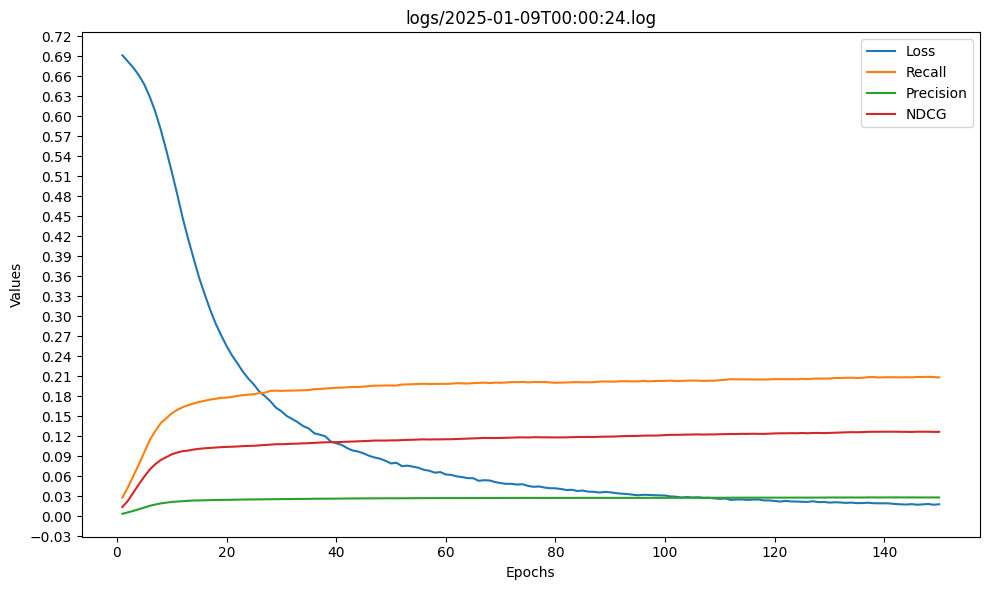

In [6]:
pp(config, width=1)
print()
print(data.iloc[-1])

plt.figure(figsize=(10, 6))


plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, ndcg, label='NDCG')


plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title(file_path)
plt.legend()

plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=30))
#plt.yscale("log")

plt.tight_layout()
plt.show()